In [96]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

import jax

key = jax.random.PRNGKey(420)
key2 = jax.random.PRNGKey(69)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)

In [97]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.1)
k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(0, None)), in_axes=(None, 0))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(0, None)), in_axes=(None, 0))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(0, None)), in_axes=(None, 0))

def true_solution_single(x):
    boundary_term = x[0]*(1-x[0])*x[1]*(1-x[1])
    interior = jnp.cos(5*jnp.pi*((0.5-x[0])**2 + (0.3*x[1])**2))
    return 4 * boundary_term * interior

true_solution=jit(jax.vmap(true_solution_single,in_axes=0))
rhs_func = jit(jax.vmap(laplacian(true_solution_single)))

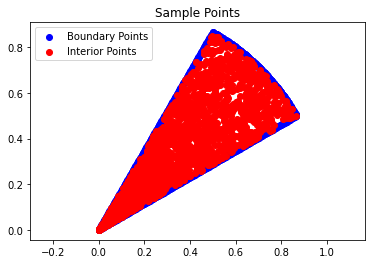

In [158]:
num_interior = 2000
num_boundary = 300
num_boundary=3*num_per_boundary

angle1 = jnp.pi/6; angle2 = jnp.pi/3

# Generate random interior points
thetas = jax.random.uniform(key, shape=(num_interior,1), minval=angle1, maxval=angle2)
rs = jax.random.uniform(key2, shape=(num_interior,1))

x_interior = rs * jnp.cos(thetas)
y_interior = rs * jnp.sin(thetas)

interior_points = jnp.column_stack((x_interior, y_interior))

# Generate points on the boundary
ts = jax.random.uniform(key, shape=(num_per_boundary,1),minval=angle1, maxval=angle2)
x_boundary = jnp.cos(ts)
y_boundary = jnp.sin(ts)
boundary_points1 = jnp.column_stack((x_boundary, y_boundary))

boundary_point_samples=np.linspace(0,1,num_per_boundary)
x_boundary = boundary_point_samples*jnp.cos(angle1)
y_boundary = boundary_point_samples*jnp.sin(angle1)
boundary_points2 = jnp.column_stack((x_boundary, y_boundary))

boundary_point_samples=np.linspace(0,1,num_per_boundary)
x_boundary = boundary_point_samples*jnp.cos(angle2)
y_boundary = boundary_point_samples*jnp.sin(angle2)
boundary_points3 = jnp.column_stack((x_boundary, y_boundary))

boundary_points = np.vstack([
    boundary_points1,
    boundary_points2,
    boundary_points3,
])

all_points = jnp.vstack([interior_points, boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], c='blue', label='Boundary Points')
plt.scatter(interior_points[:, 0], interior_points[:, 1], c='red', label='Interior Points')
plt.legend()
plt.axis('equal')
plt.show()

In [161]:
K1 = vec_k_laplap(interior_points,interior_points)
K2 = vec_k_lapx(boundary_points,interior_points)
K3 = K2.T
K4 = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [K1,K2],
        [K3,K4]
    ]
)

interior_rhs = rhs_func(interior_points)
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

In [165]:
nugget=1e-10
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))
coef_sol=jax.scipy.linalg.solve(Kmat,rhs_total,assume_a='pos')
residual = rhs_total - K_full@coef_sol
coef_sol_refined=coef_sol+jax.scipy.linalg.solve(Kmat,residual,assume_a='pos')

residual_refined = rhs_total - K_full@coef_sol_refined

eval_K=vec_k(interior_points,all_points).T
sol_vals = eval_K@coef_sol

In [193]:
num_grid = 20000
# Generate random interior points
thetas = jax.random.uniform(key, shape=(num_interior,1), minval=angle1, maxval=angle2)
rs = jax.random.uniform(key2, shape=(num_interior,1))

xgrid = rs * jnp.cos(thetas)
ygrid = rs * jnp.sin(thetas)

plt_points = jnp.column_stack((xgrid, ygrid))
XX,YY=jnp.meshgrid(xgrid[:,0],ygrid[:,0])
interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T
interp_k = jnp.block(
    [
        [vec_k_lapx(interior_points,interpolation_points),vec_k(boundary_points,interpolation_points)]
    ]
)

interp_solution=(interp_k@coef_sol).reshape(num_grid_points,num_grid_points)
interp_solution_refined=(interp_k@coef_sol_refined).reshape(num_grid_points,num_grid_points)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 128000000000 bytes.

In [195]:
interior_points.shape

(2000, 2)

KeyboardInterrupt: 

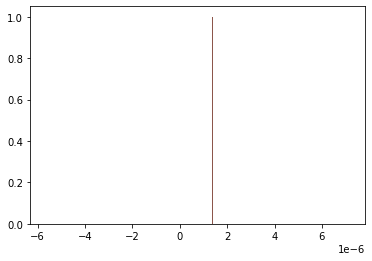

In [9]:
plt.hist(error.flatten(),50,alpha=0.5)
plt.hist(error_refined.flatten(),50,alpha=0.5)

plt.show()